In [1]:
from dataclasses import dataclass
from pathlib import Path

import missingno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = Path.cwd().parent.parent / "data"

In [3]:
# Give things names for easy joining
@dataclass
class ColumnSpecs:
    filename: str
    question_of_interest: str
    respondent_id: str
    survey_name: str


# Base outcome data
base_specs = [
    ColumnSpecs(
        DATA_DIR
        / "Sixth_wave/TPL_Testing_Survey_SixthWave_YouGov_RI_with_past_IDs.sav",
        "q120",
        "caseid",
        "sixth_ri",
    ),
    ColumnSpecs(
        DATA_DIR
        / "Sixth_wave/TPL_Testing_Survey_SixthWave_YouGov_US_with_past_IDs.sav",
        "q120",
        "caseid",
        "sixth_us",
    ),
]

# Historic data we'll join to
to_join_specs = [
    ColumnSpecs(
        DATA_DIR / "Third_Wave/TPL_Testing_Survey_ThirdWave_YouGov.sav",
        "q1",
        "caseid_15",
        "third",
    ),
    ColumnSpecs(
        DATA_DIR / "Fourth_Wave/TPL_Testing_Survey_FourthWave_YouGov.sav",
        "q1",
        "caseid_16",
        "fourth",
    ),
    ColumnSpecs(
        DATA_DIR / "Seventh_wave/TPL_Testing_Survey_SeventhWave_YouGov.sav",
        "q180",
        "caseid_20",
        "seventh",
    ),
]

In [4]:
# Create a standard user_id based on historic data from sixth and seventh surveys

id_dfs = []

# Concatentate sixth survey files
df = pd.read_spss(base_specs[0].filename)
id_dfs.append(df[["caseid", "caseid_15", "caseid_16", "caseid_17"]].astype("Int64"))

df = pd.read_spss(base_specs[1].filename)
id_dfs.append(df[["caseid", "caseid_15", "caseid_16", "caseid_17"]].astype("Int64"))

id_df = pd.concat(id_dfs)
id_df.rename(columns={"caseid": "caseid_19"}, inplace=True)

# Open seventh survey
df = pd.read_spss("../../data/Seventh_wave/TPL_Testing_Survey_SeventhWave_YouGov.sav")
df[[col for col in df.columns if "caseid" in col]]

# Check: at most one of caseid_19 is non-null
assert (~(df["caseid_BROW0019_Nat"].notna() & df["caseid_BROW0019_RI"].notna())).all()
df["caseid_19"] = df["caseid_BROW0019_Nat"].fillna(df["caseid_BROW0019_RI"])
df.drop(columns=["caseid_BROW0019_Nat", "caseid_BROW0019_RI"], inplace=True)
df.rename(columns={col: col.replace("BROW00", "") for col in df}, inplace=True)
df = df[["caseid", "caseid_15", "caseid_16", "caseid_17", "caseid_19"]]
for col in df:
    if col.startswith("caseid"):
        df[col] = df[col].astype("Int64")

df.rename(columns={"caseid": "caseid_20"}, inplace=True)

# Merge ids
id_df = id_df.merge(df, on="caseid_19", how="outer", suffixes=["", "_x"])

# Make sure nothing funny happened between here and YouGov
for col in id_df:
    if f"{col}_x" in id_df:
        assert (id_df[col] == id_df[f"{col}_x"]).all()

id_df = id_df[[col for col in id_df if not col.endswith("_x")]]

<AxesSubplot:>

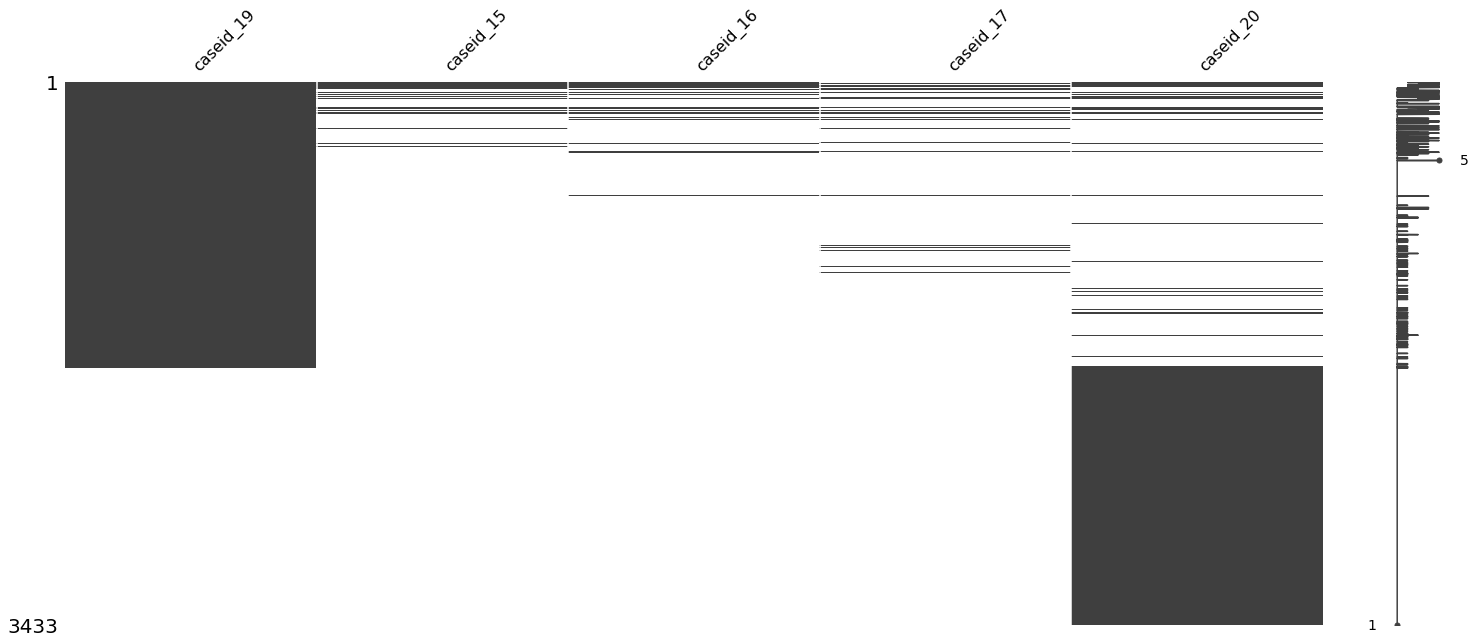

In [5]:
missingno.matrix(id_df)

In [6]:
# Merge in data

dfs = []
for spec in base_specs:
    df = pd.read_spss(spec.filename)
    df["caseid"] = df["caseid"].astype("Int64")
    df = df[["caseid", spec.question_of_interest]].rename(
        columns={"caseid": "caseid_19", spec.question_of_interest: "sixth_answer"}
    )
    dfs.append(df)

data_df = id_df.merge(pd.concat(dfs), how="left", on="caseid_19")

for spec in to_join_specs:
    df = pd.read_spss(spec.filename)
    df[["caseid", spec.question_of_interest]]
    df["caseid"] = df["caseid"].astype("Int64")
    df.rename(
        columns={
            "caseid": spec.respondent_id,
            spec.question_of_interest: f"{spec.survey_name}_answer",
        },
        inplace=True,
    )

    data_df = data_df.merge(
        df[[spec.respondent_id, f"{spec.survey_name}_answer"]],
        on=spec.respondent_id,
        how="left",
    )

In [7]:
data_df.head()

,caseid_19,caseid_15,caseid_16,caseid_17,caseid_20,sixth_answer,third_answer,fourth_answer,seventh_answer
0,1619121243,1267124497,1308368411,1394204563,<NA>,"Yes, got both doses of a two-dose vaccine (Mo...",Definitely will,Definitely will,NaN
1,1619121269,1265155309,1300759427,1401653495,1719381813,"Yes, got both doses of a two-dose vaccine (Mo...",Definitely will,Definitely will,"Yes, got both doses of a two-dose vaccine (Mod..."
2,1619134793,1266377491,1299258531,1401653445,<NA>,"Yes, got both doses of a two-dose vaccine (Mo...",Maybe will,Not sure,NaN
3,1618564661,<NA>,<NA>,1398318671,1721078843,"Yes, got both doses of a two-dose vaccine (Mo...",NaN,NaN,"Yes, got both doses of a two-dose vaccine (Mod..."
4,1619148885,1266730067,<NA>,<NA>,<NA>,"Yes, got both doses of a two-dose vaccine (Mo...",Definitely will,NaN,NaN


<AxesSubplot:>

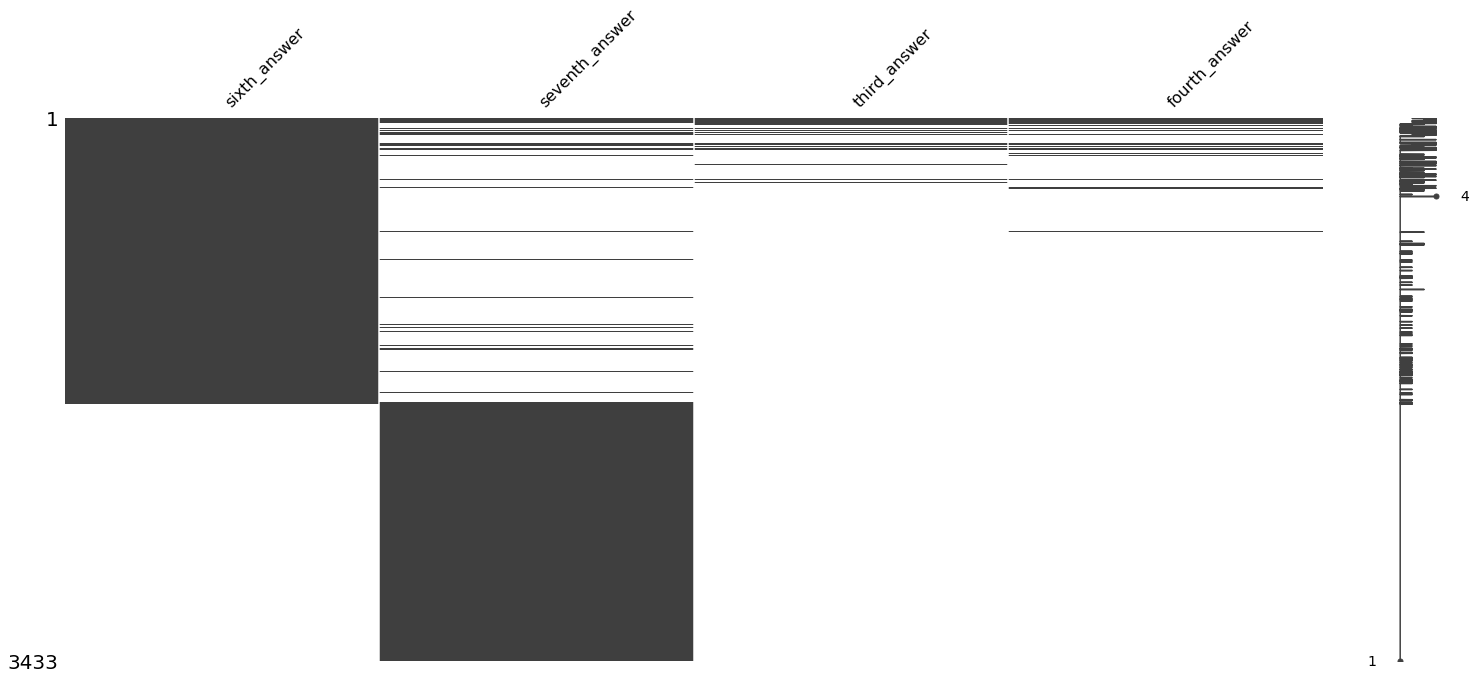

In [8]:
# Visually, there definitely exists overlap, but it's not super high
missingno.matrix(
    data_df[["sixth_answer", "seventh_answer", "third_answer", "fourth_answer"]]
)

In [9]:
# Distribution of outcome answer
data_df["sixth_answer"].value_counts()

Yes, got both doses of a two-dose vaccine  (Moderna or Pfizer)    980
No, have not gotten the vaccine                                   390
Yes, got fully vaccinated plus a booster shot                     259
Yes, got the one-dose vaccine (J&J)                               100
Yes, got first dose of a two-dose vaccine (Moderna or Pfizer)      80
Name: sixth_answer, dtype: int64

In [10]:
data_df["seventh_answer"].value_counts()

Yes, got both doses of a two-dose vaccine (Moderna or Pfizer) plus a booster shot    856
No, have not gotten the vaccine                                                      404
Yes, got both doses of a two-dose vaccine (Moderna or Pfizer) but no booster         331
Yes, got a one-dose vaccine (J&J) plus a booster shot                                 81
Yes, got the one-dose vaccine (J&J) but no booster                                    60
Yes, got first dose of a two-dose vaccine (Moderna or Pfizer)                         55
Yes, got primary series of COVID-19 vaccine not listed here plus a booster shot        9
Yes, got primary series of COVID-19 vaccine not listed here                            4
Name: seventh_answer, dtype: int64

In [11]:
# We'll convert any "Yes" (including single dose) to 1; else 0
data_df["sixth_answer_num"] = (
    data_df["sixth_answer"].map(lambda x: 1 if "Yes" in x else 0).astype("Int64")
)
assert (data_df["sixth_answer_num"].isna() == data_df["sixth_answer"].isna()).all()

# Sanity check: Matches above
data_df["sixth_answer_num"].value_counts(dropna=False)

<NA>    1624
1       1419
0        390
Name: sixth_answer_num, dtype: Int64

In [12]:
# We'll convert any "Yes" (including single dose) to 1; else 0
data_df["seventh_answer_num"] = (
    data_df["seventh_answer"].map(lambda x: 1 if "Yes" in x else 0).astype("Int64")
)
assert (data_df["seventh_answer_num"].isna() == data_df["seventh_answer"].isna()).all()

# Sanity check: Matches above
data_df["seventh_answer_num"].value_counts(dropna=False)

<NA>    1633
1       1396
0        404
Name: seventh_answer_num, dtype: Int64

In [13]:
# Distribution of third answer; note the very large number of missing
data_df["third_answer"].value_counts(dropna=False)

NaN                 3294
Definitely will       53
Maybe will            39
Not sure              22
Definitely won't      14
Maybe won't           11
Name: third_answer, dtype: int64

In [14]:
# Distribution of fourth answer; note the very large number of missing
data_df["fourth_answer"].value_counts(dropna=False)

NaN                 3307
Definitely will       73
Not sure              18
Definitely won't      15
Maybe will            14
Maybe won't            6
Name: fourth_answer, dtype: int64

In [15]:
# 139 answered 3 + 6; 126 answered 4 + 6; of these 100 answered 3 + 4 + 6
both_answer_filter = data_df["third_answer"].notna() & data_df["fourth_answer"].notna()
both_answer_filter.sum()

100

In [16]:
# Note that this is the same number if you only look at people who answered the sixth
# survey
both_answer_filter = (
    data_df["third_answer"].notna()
    & data_df["fourth_answer"].notna()
    & data_df["sixth_answer"].notna()
)
both_answer_filter.sum()

100

In [17]:
# And 67 people answered all four
both_answer_filter = (
    data_df["third_answer"].notna()
    & data_df["fourth_answer"].notna()
    & data_df["seventh_answer"].notna()
)
both_answer_filter.sum()

67

In [18]:
# Reset back to third/fourth/sixth since it's the superset
both_answer_filter = (
    data_df["third_answer"].notna()
    & data_df["fourth_answer"].notna()
    & data_df["sixth_answer"].notna()
)

In [19]:
# Reliability: How many people answered 3 and 4 _exactly_ the same
(
    data_df.loc[both_answer_filter, "third_answer"]
    == data_df.loc[both_answer_filter, "fourth_answer"]
).mean()

0.58

In [20]:
# Change labels to values
label_to_val = {
    "Definitely will": 5,
    "Maybe will": 4,
    "Not sure": 3,
    "Maybe won't": 2,
    "Definitely won't": 1,
}

for name in ["third_answer", "fourth_answer"]:
    data_df[f"{name}_num"] = (
        data_df[name].map(label_to_val, na_action="ignore").astype("Int64")
    )

In [21]:
# Reliability: How many people said (Def will / Maybe will) or (Not sure / Maybe won't / Def won't) twice
(
    (data_df.loc[both_answer_filter, "third_answer_num"] >= 4)
    == (data_df.loc[both_answer_filter, "fourth_answer_num"] >= 4)
).mean()

0.81

In [22]:
# Reliability: How many people said (Def will / Maybe will / Not sure) or (Maybe won't / Def won't) twice

(
    (data_df.loc[both_answer_filter, "third_answer_num"] >= 3)
    == (data_df.loc[both_answer_filter, "fourth_answer_num"] >= 3)
).mean()

0.89

In [23]:
# Reliability: How many people said (Def will / Maybe will) at least once
(
    (data_df.loc[both_answer_filter, "third_answer_num"] >= 4)
    | (data_df.loc[both_answer_filter, "fourth_answer_num"] >= 4)
).sum()

78

In [24]:
# Outcome: How many people said (Def will / Maybe will) at least once AND got vaccinated

(
    (data_df.loc[both_answer_filter, "sixth_answer_num"] == 1)
    & (
        (data_df.loc[both_answer_filter, "third_answer_num"] >= 4)
        | (data_df.loc[both_answer_filter, "fourth_answer_num"] >= 4)
    )
).sum()

76

In [25]:
# Reliability: How many people said (Not sure / Maybe wont' / Def won't) twice

(
    (data_df.loc[both_answer_filter, "third_answer_num"] <= 3)
    & (data_df.loc[both_answer_filter, "fourth_answer_num"] <= 3)
).sum()

22

In [26]:
# Outcome: How many people said (Not sure / Maybe wont' / Def won't) twice AND did NOT get vaccinated

(
    (data_df.loc[both_answer_filter, "sixth_answer_num"] == 0)
    & (
        (data_df.loc[both_answer_filter, "third_answer_num"] <= 3)
        & (data_df.loc[both_answer_filter, "fourth_answer_num"] <= 3)
    )
).sum()

12

In [27]:
# Reliability: How many people said (Maybe won't / Def won't) twice

(
    (data_df.loc[both_answer_filter, "third_answer_num"] <= 2)
    & (data_df.loc[both_answer_filter, "fourth_answer_num"] <= 2)
).sum()

11

In [28]:
# Outcome: How many people said (Maybe won't / Def won't) twice AND did NOT get vaccinated

(
    (data_df.loc[both_answer_filter, "sixth_answer_num"] == 0)
    & (
        (data_df.loc[both_answer_filter, "third_answer_num"] <= 2)
        & (data_df.loc[both_answer_filter, "fourth_answer_num"] <= 2)
    )
).sum()

9

In [29]:
# Among people who answered the sixth and seventh surveys, do their answers match? No. But almost always
tmp_df = data_df[
    data_df["sixth_answer_num"].notna() & data_df["seventh_answer_num"].notna()
]
(tmp_df["sixth_answer_num"] == tmp_df["seventh_answer_num"]).mean()

0.9715909090909091

In [30]:
# Do they at least always increase? I.e., go from unvax to vax? No. But once again almost all
tmp_df = data_df[
    data_df["sixth_answer_num"].notna() & data_df["seventh_answer_num"].notna()
]
(tmp_df["sixth_answer_num"] <= tmp_df["seventh_answer_num"]).mean()

0.9943181818181818

In [31]:
# Only one person did not increase. This person didn't answer surveys three or four, so
# shouldn't really affect our further analysis
tmp_df = data_df[
    data_df["sixth_answer_num"].notna() & data_df["seventh_answer_num"].notna()
]
tmp_df[tmp_df["sixth_answer_num"] > tmp_df["seventh_answer_num"]]

,caseid_19,caseid_15,caseid_16,caseid_17,caseid_20,sixth_answer,third_answer,fourth_answer,seventh_answer,sixth_answer_num,seventh_answer_num,third_answer_num,fourth_answer_num
1216,1618955829,<NA>,<NA>,<NA>,1726264187,"Yes, got both doses of a two-dose vaccine (Mo...",NaN,NaN,"No, have not gotten the vaccine",1,0,<NA>,<NA>


In [32]:
# Take as our IV of interest, people's _last in time_ answer about their intentions
data_df["combined_intention_answer"] = data_df["fourth_answer_num"].fillna(
    data_df["third_answer_num"]
)

# Take as our DV of interest people's _max_ vaccination status
data_df["combined_action_answer"] = data_df[
    ["sixth_answer_num", "seventh_answer_num"]
].max(axis=1)

final_df = data_df[data_df["combined_intention_answer"].notna()]

In [33]:
# Main outcome: How many people said they (Def will / Maybe will) get vaccinated and DID get vaccinated
just_will = final_df[final_df["combined_intention_answer"] >= 4]
just_will["combined_action_answer"].mean(), len(just_will)

(0.9910714285714286, 112)

In [34]:
# Main outcome: How many people said they (Def won't / Maybe won't) get vaccinated and DID NOT get vaccinated
just_will = final_df[final_df["combined_intention_answer"] <= 2]
(1 - just_will["combined_action_answer"].mean()), len(just_will)

(0.5806451612903225, 31)

### Demographics

In [35]:
just_36_df = id_df[id_df[["caseid_15", "caseid_19"]].notna().all(axis=1)]
just_46_df = id_df[id_df[["caseid_16", "caseid_19"]].notna().all(axis=1)]

In [36]:
demo_concat = pd.concat([just_36_df, just_46_df])
demo_df = pd.concat([pd.read_spss(spec.filename) for spec in base_specs])
demo_df = demo_df[demo_df["caseid"].isin(demo_concat["caseid_19"].values)]
len(demo_df)

165

In [37]:
# Age

df_ages = 2021 - demo_df.birthyr
ages_range = pd.cut(df_ages, bins=[0, 18, 25, 40, 65, 120])
ages_range.value_counts()

(40, 65]     80
(65, 120]    61
(25, 40]     20
(18, 25]      4
(0, 18]       0
Name: birthyr, dtype: int64

In [38]:
# Age Mean

df_ages.mean()

58.096969696969694

In [39]:
# Gender

demo_df.gender.value_counts()

Female    88
Male      77
Name: gender, dtype: int64

In [40]:
# Race

demo_df.race.value_counts()

White                142
Hispanic               8
Other                  8
Black                  5
Asian                  1
Two or more races      1
Middle Eastern         0
Native American        0
Name: race, dtype: int64

In [41]:
# Education

demo_df.educ.value_counts()

4-year                  46
High school graduate    35
Post-grad               32
Some college            32
2-year                  19
No HS                    1
Name: educ, dtype: int64

In [42]:
# State

demo_df.inputstate.value_counts()

Rhode Island      155
Pennsylvania        2
North Carolina      1
Mississippi         1
Wisconsin           1
Florida             1
Washington          1
New York            1
Oregon              1
California          1
Name: inputstate, dtype: int64

#### Visual Plots

In [43]:
# Plot data
## tr = translation rate; prop = proportion

plot_data = {
    "Authors": [
        "Lehmann",
        "Ye",
        "Rodas",
        "Liao",
        "Wang",
        "Kirzinger",
        "Evans",
        "Campos-Mercade",
    ],
    "Location": [
        "Netherlands",
        "China",
        "Hong Kong",
        "Hong Kong",
        "China",
        "United States",
        "United States",
        "Sweden",
    ],
    "Disease": [
        "Influenza",
        "Influenza",
        "H1N1",
        "H1N1",
        "COVID",
        "COVID",
        "COVID",
        "COVID",
    ],
    "tr_pos_int": [73.90, 16.87, 7.89, 5.97, 81.8, 92.0, np.NaN, np.NaN],
    "tr_neg_int": [1.30, 0.00, np.NaN, np.NaN, 61.3, 24.0, 59.7, np.NaN],
    "prop_pos_int": [75.56, 99.33, np.NaN, 57.14, 91.84, 47.0, np.NaN, np.NaN],
    "prop_neg_int": [3.33, 0.00, np.NaN, np.NaN, 8.15, 5.0, np.NaN, np.NaN],
}
plot_df = pd.DataFrame(data=plot_data)

In [44]:
tr_plot_df = pd.melt(
    plot_df, id_vars=["Disease"], value_vars=["tr_pos_int", "tr_neg_int"]
)

[Text(0.5, 1.0, 'Proportion of Vaccinated Respondents by Disease')]

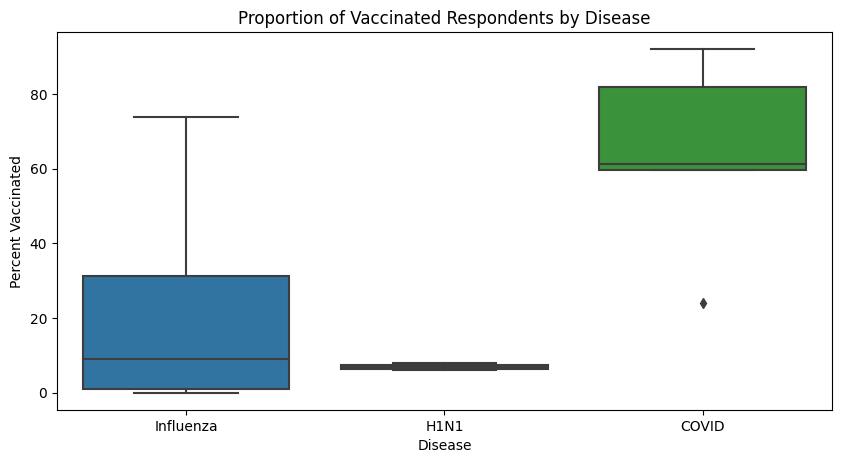

In [45]:
# Translation rate plot (of those who intended, how many were vaccinated)

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

plot = sns.boxplot(data=tr_plot_df, x="Disease", y="value")

ax.set(ylabel="Percent Vaccinated")
ax.set(title="Proportion of Vaccinated Respondents by Disease (Translation Rate)")

In [46]:
prop_plot_df = pd.melt(
    plot_df, id_vars=["Disease"], value_vars=["prop_pos_int", "prop_neg_int"]
)

[Text(0.5, 1.0, 'Proportion of Vaccinated Respondents by Disease')]

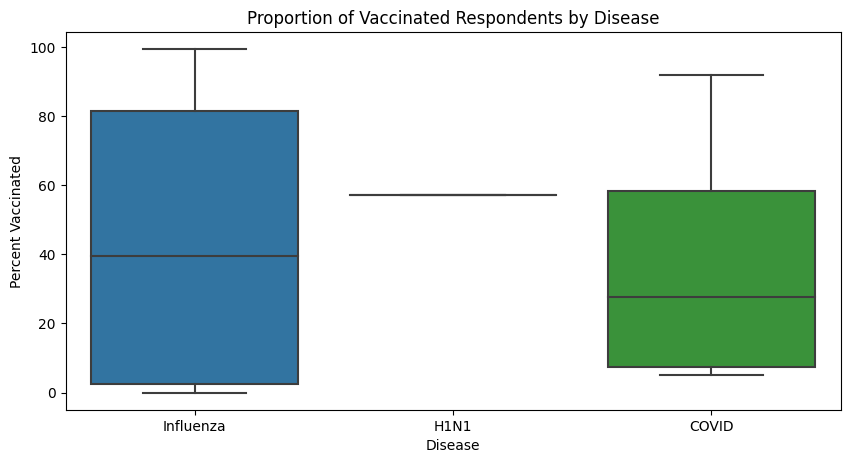

In [47]:
# Proportion plot (of those vaccinated, how many intended)

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

plot = sns.boxplot(data=prop_plot_df, x="Disease", y="value")

ax.set(ylabel="Percent Vaccinated")
ax.set(title="Proportion of Vaccinated Respondents by Disease")